In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd
from itertools import combinations
import collections

In [3]:
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42  # Use TrueType fonts in PDF
mpl.rcParams['ps.fonttype'] = 42   # Use TrueType fonts in PS

In [4]:
methods = ['epsilon','ts','ucb','sh']
methodnames = dict(zip(methods,['EpsilonNet','ThompsonSampling','UpperConfidenceBound','SuccessiveHalving']))
colormap = dict(zip(methods, ['#8ac926','#ffca3a','#ff595e','#669bbc']))
plt.rcParams.update({'font.size': 14})

First

In [11]:
IfStationary=True
length_scale=1
K=5
num_points=15
actionspace = np.linspace(0,2,num_points)
fun=GPfunctions(K,length_scale=length_scale,IfStationary=IfStationary,actionspace=actionspace)
kernel=fun.kernel
output_ep=[]
output_sh=[]
for ignore in range(50):
    fun=GPfunctions(K,length_scale=length_scale,IfStationary=IfStationary,actionspace=actionspace,kernel=kernel)
    output_ep+=[fun.test(fun.subset)]
    arm_seq, pull_seq=fun.run_sh_sequence()
    output_sh+=[[fun.test(arm) for arm in arm_seq]]

In [52]:
pull_seq

[3003,
 6005,
 9005,
 12005,
 14997,
 18066,
 21148,
 24230,
 27310,
 30390,
 33472,
 36555]

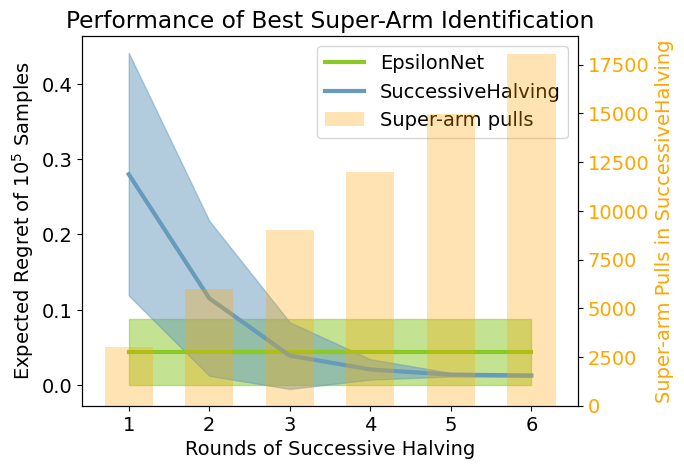

In [12]:
fig, ax1 = plt.subplots()

# X-axis: time periods
window_length=6
periods = np.arange(1, window_length + 1)

# ep
mean,std=compute_meanstd(output_ep)
# Plot mean and shaded ±1 std region
ax1.plot(periods, [mean]*len(periods), label=methodnames['epsilon'], color=colormap['epsilon'],linewidth=3)
ax1.fill_between(periods, [mean-std]*len(periods), [mean+std]*len(periods), color=colormap['epsilon'], alpha=0.5)

# sh
mean,std=compute_meanstd(output_sh)
mean=mean[0:window_length]
std=std[0:window_length]

# Plot mean and shaded ±1 std region
ax1.plot(periods, mean, label=methodnames['sh'], color=colormap['sh'],linewidth=3)
ax1.fill_between(periods, mean - std, mean + std, color=colormap['sh'], alpha=0.5)

ax1.set_ylabel(r"Expected Regret of $10^5$ Samples")
ax1.tick_params(axis='y')

# Create a secondary y-axis for the bars
ax2 = ax1.twinx()
ax2.bar(periods, pull_seq[0:window_length], label='Super-arm pulls',
        color='orange', alpha=0.3, width=0.6)
ax2.set_ylabel('Super-arm Pulls in SuccessiveHalving', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Get handles and labels from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# Combine them and add one legend to ax1
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Shared x-axis
ax1.set_xlabel('Rounds of Successive Halving')
plt.title('Performance of Best Super-Arm Identification')
# plt.grid(True)
plt.savefig("RKHS_BAI.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

Second

In [27]:
IfStationary=True
report=pd.DataFrame(columns=['EmpiricialRegret','length_scale','K','method'])
length_range=[0.5,1,1.5,2,2.5,3,4] 
K=5
for length_scale in length_range:
    fun=GPfunctions(K,length_scale=length_scale,IfStationary=IfStationary)
    kernel=fun.kernel
    for ignore in range(50):
        fun=GPfunctions(K,length_scale=length_scale,IfStationary=IfStationary,kernel=kernel)
        output=fun.test(fun.subset)
        sh=fun.test(fun.run_sh(budget=37000))
        ucb=fun.test(fun.run_ucb(time_steps=3000))
        ts=fun.test(fun.run_ts(time_steps=3000))
        row=pd.Series({'EmpiricialRegret':output,'length_scale':length_scale,'K':K,'method':'epsilon'})
        row_sh=pd.Series({'EmpiricialRegret':sh,'length_scale':length_scale,'K':K,'method':'sh'})
        row_ucb=pd.Series({'EmpiricialRegret':ucb,'length_scale':length_scale,'K':K,'method':'ucb'})
        row_ts=pd.Series({'EmpiricialRegret':ts,'length_scale':length_scale,'K':K,'method':'ts'})
        report = pd.concat([report,row.to_frame().T,row_sh.to_frame().T,row_ucb.to_frame().T,row_ts.to_frame().T], ignore_index=True)
        # report = pd.concat([report,row.to_frame().T,row_ucb.to_frame().T,row_ts.to_frame().T], ignore_index=True)

In [13]:
# report.to_csv('report_rbf.csv',index=None)
report=pd.read_csv('report_rbf.csv')
length_range=[0.5,1,1.5,2,2.5,3,4] 

In [14]:
fig, ax = plt.subplots()  # (rows, cols) #figsize=(12,4)
K=5

for m in methods:
    dfmean=report.groupby(by=["length_scale",'K','method']).mean()['EmpiricialRegret']
    mean=np.array([dfmean[l][K][m] for l in length_range])
    dfstd=report.groupby(by=["length_scale",'K','method']).std()['EmpiricialRegret']
    std=np.array([dfstd[l][K][m] for l in length_range])
    ax.plot(length_range, mean, label="{}".format(methodnames[m]), color=colormap[m],linewidth=3)
    ax.fill_between(length_range, mean-std, mean+std, color=colormap[m],alpha=0.4)

# axes[i].set_ylim([-0.05,0.5])
ax.set_title('Performance under RBF Kernel') #"K={} out of 15 Actions".format(krange[i])
ax.set_xlabel("Length Scale of RBF Kernel")
ax.set_xticks(length_range)
ax.set_ylabel(r"Expected Regret of $10^5$ Samples")
ax.legend()
# # Move the left spine (axis line) to the right
# ax.yaxis.tick_right()  # Move ticks to the right
# ax.yaxis.set_label_position("right")  # Move the label to the right
plt.savefig("RKHS_RBF.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

Third

In [15]:
num_points=1000
gibbs=gibbsmatrix(num_points=num_points)
actionspace=gibbs.actionspace
kernel=gibbs.kernel
batch_size=5000
all_counts = collections.Counter()
# Run fun.subset() many times and update the counts
fun=GPfunctions_Epsilon(K=batch_size,actionspace=actionspace,kernel=kernel)
indices = fun.subset  # Should return a subset (e.g., list or set) of indices
all_counts.update(indices)

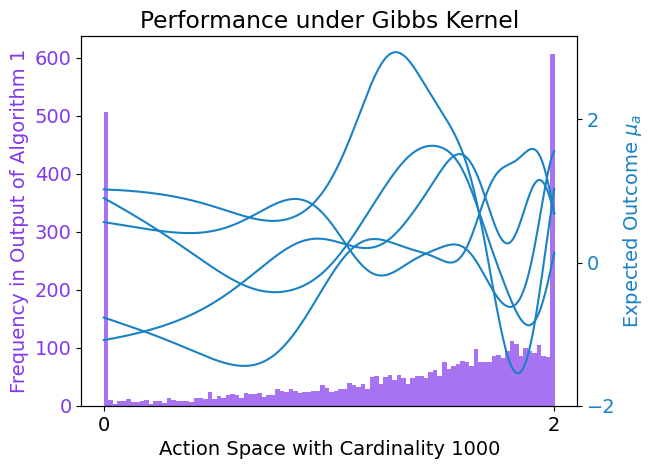

In [16]:
fig, ax1 = plt.subplots()

# First plot (left y-axis)
color1 = '#8338ec'

# Group indices into one bin
bin_size = 10
num_bins = num_points // bin_size
grouped_histogram = [sum(all_counts[i] for i in range(b * bin_size, (b + 1) * bin_size)) for b in range(num_bins)]
# Plot the grouped histogram
ax1.bar([b * bin_size + bin_size/2  for b in range(num_bins)], grouped_histogram, width=bin_size,alpha=0.7,color=color1)
ax1.set_xlabel('Action Space with Cardinality {}'.format(num_points))
ax1.set_xticks([0,999])
ax1.set_xticklabels([0,2])
ax1.set_ylabel('Frequency in Output of Algorithm 1', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_title('Performance under Gibbs Kernel')

# Second y-axis
ax2 = ax1.twinx()
color2 = '#1982c4' #"#2a9d8f"
ax2.set_ylabel(r'Expected Outcome $\mu_a$', color=color2)
batch_size=5
fun=GPfunctions_Epsilon(K=1,actionspace=actionspace,kernel=kernel)
fun_samples=fun.samples(size=batch_size)
for i in range(batch_size):
    ax2.plot([*range(num_points)],fun_samples[i,:],color=color2)
ax2.set_yticks([2, 0, -2])  # set the tick positions
ax2.tick_params(axis='y', labelcolor=color2)
plt.savefig("RKHS_Gibbs.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

Functions

In [5]:
def compute_meanstd(output):
    # Convert to NumPy array: shape (num_trajectories, 3)
    arr = np.array(output)

    # Compute mean and std across axis=0 (i.e., across trajectories for each period)
    mean = np.mean(arr, axis=0)
    std = np.std(arr, axis=0)
    return mean, std

In [6]:
class UCBPolicy:
    def __init__(self, K):
        self.K=K
        self.counts = np.zeros(K, dtype=int)     # Number of times each arm has been pulled
        self.values = np.zeros(K, dtype=float)   # Empirical means of each arm
        self.total_time = 0                      # Global time step

    def select_arm(self):
        self.total_time += 1
        t = self.total_time

        if t <= self.K:
            # Force one pull per arm in the first K rounds
            return t - 1

        # UCB1 formula assuming known variance = 1
        ucb_values = self.values + np.sqrt(2 * np.log(t) / (self.counts + 1e-8))
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        """Update empirical mean of selected arm with new reward."""
        self.counts[arm] += 1
        n = self.counts[arm]
        old_mean = self.values[arm]
        self.values[arm] = old_mean + (reward - old_mean) / n

    def get_estimates(self):
        return self.values

    def get_counts(self):
        return self.counts

In [7]:
class GaussianTS:
    def __init__(self, n_arms, known_variance=1.0):
        self.n_arms = n_arms
        self.prior_mean = np.zeros(n_arms)
        self.prior_precision = np.ones(n_arms) * 1e-6  # Start with vague prior
        self.known_variance = known_variance

    def select_arm(self):
        sampled_means = np.random.normal(
            self.prior_mean,
            np.sqrt(self.known_variance / self.prior_precision)
        )
        return np.argmax(sampled_means)

    def update(self, arm, reward):
        self.prior_precision[arm] += 1
        self.prior_mean[arm] += (reward - self.prior_mean[arm]) / self.prior_precision[arm]

In [8]:
class GPfunctions_Epsilon:
    def __init__(self, K, length_scale=None, actionspace=None, kernel=None):
        self.K=K
        self.length_scale=length_scale
        self.actionspace=actionspace
        self.kernel=kernel
        self.num_points=len(actionspace)
        if len(actionspace)==0:
            self.num_points= 1000 #number of actions
            actionspace =  np.linspace(0,2,self.num_points) #.reshape(-1, 1) # grid points
            self.actionspace = np.sort(actionspace,axis=0)        
            # Compute covariance matrix
            if IfStationary == True:
                self.kernel = self.rbf_kernel()
            else:
                self.kernel = self.gibbs_kernel()
        self.subset = self.algorithm()

    # Stationary Gaussian Kernel
    def rbf_kernel(self):
        """Computes the RBF kernel matrix."""
        actionset=self.actionspace.reshape((-1,1))
        sq_dist = cdist(actionset,actionset, 'sqeuclidean')
        return np.exp(-sq_dist / (2 * self.length_scale ** 2))

    def samples(self,size):
        # Sample multiple functions from the GP
        return np.random.multivariate_normal(mean=np.zeros(self.num_points), cov=self.kernel,size=size)

    def algorithm(self):
        # Sample multiple functions from the GP
        f_samples = self.samples(size=self.K)
        # Find the max index for each batch
        max_indices = np.argmax(f_samples, axis=1)  # Shape: (num_batches,)
        # Get unique max indices
        # subset = np.unique(max_indices)
        # while len(subset)< self.K: # add more items until K distinct actions are found
        #     f_samples = self.samples(size=self.K-len(subset))
        #     max_indices = np.argmax(f_samples, axis=1)
        #     subset = np.append(subset,np.unique(max_indices))
        # # print("Unique actions:", subset)
        return max_indices

In [9]:
class gibbsmatrix:
    def __init__(self, num_points=1000,length_scale=0.1):
        self.num_points= num_points#number of actions
        actionspace =  np.linspace(0,2,self.num_points) #.reshape(-1, 1) # grid points
        self.actionspace = np.sort(actionspace,axis=0)        
        # Compute covariance matrix
        self.length_scale=length_scale
        self.kernel = self.gibbs_kernel()

    # Non-stationary Gibbs Kernel
    def gibbs_kernel(self):
        """Computes the Gibbs kernel matrix."""
        K = np.zeros((self.num_points,self.num_points))
        # Compute the kernel matrix
        for i in range(self.num_points):
            for j in range(self.num_points):
                K[i,j] = self.gibbs_kernel_fun(self.actionspace[i],self.actionspace[j])
        return K

    # Define an input-dependent length scale function l(x)
    def length_scale_fun(self, x):
        return self.length_scale + (1-self.length_scale)*np.exp(-x**2)  # Short length scale near 0, longer away

    # Define the 1D Gibbs kernel function
    def gibbs_kernel_fun(self, x, x_prime):
        l_x = self.length_scale_fun(x)
        l_xp = self.length_scale_fun(x_prime)
        numerator = 2 * l_x * l_xp
        denominator = l_x**2 + l_xp**2
        prefactor = np.sqrt(numerator / denominator)
        exponent = - (x - x_prime)**2 / denominator
        return prefactor * np.exp(exponent)

In [10]:
class GPfunctions:
    def __init__(self, K, length_scale=None, IfStationary=True, actionspace=None, kernel=None):
        self.K=K
        self.length_scale=length_scale
        if actionspace is None:
            self.num_points= 15 #number of actions
            actionspace =  np.linspace(0,2,self.num_points) #.reshape(-1, 1) # grid points
        self.num_points = len(actionspace)
        self.actionspace = np.sort(actionspace,axis=0)
        # Compute covariance matrix
        if IfStationary and kernel is None:
            self.kernel = self.rbf_kernel()
        else:
            self.kernel = kernel # gibbs kernel is slow to compute 
        self.subset = self.algorithm()
        self.geneate_combinations()
    
    def geneate_combinations(self):
        # Generate all K-action combinations
        all_combinations = list(combinations(range(self.num_points), self.K))
        # Create both dictionaries
        self.combination_index = {comb: idx for idx, comb in enumerate(all_combinations)}
        self.index_combination = {idx: comb for idx, comb in enumerate(all_combinations)}
        self.num_superarm = len(self.combination_index) # number of super arm
        # # Example usage:
        # example_comb = (0, 1, 2, 3, 4)
        # example_idx = 1234
        
    # Stationary Gaussian Kernel
    def rbf_kernel(self):
        """Computes the RBF kernel matrix."""
        actionset=self.actionspace.reshape((-1,1))
        sq_dist = cdist(actionset,actionset, 'sqeuclidean')
        return np.exp(-sq_dist / (2 * self.length_scale ** 2))

    def samples(self,size):
        # Sample multiple functions from the GP
        return np.random.multivariate_normal(mean=np.zeros(self.num_points), cov=self.kernel, size=size)

    def algorithm(self):
        # Sample multiple functions from the GP
        f_samples = self.samples(size=self.K)
        # Find the max index for each batch
        max_indices = np.argmax(f_samples, axis=1)  # Shape: (num_batches,)
        # Get unique max indices
        subset = np.unique(max_indices)

        total_steps=len(subset)
        while len(subset) < self.K: # add more items until K distinct actions are found
            total_steps+=self.K-len(subset)
            f_samples = self.samples(size=self.K-len(subset))
            max_indices = np.argmax(f_samples, axis=1)
            subset = np.unique(np.append(subset,max_indices))
        # print("Unique actions:", subset)

        # print("total samples of bandit instances of ep:",total_steps)
        self.ep_steps=total_steps
        return list(subset)
    
    def test(self,subset):
        num_batches = 10**5  # Number of function samples for testing
        # Sample multiple functions from the GP
        f_samples = self.samples(size=num_batches) # np.random.multivariate_normal(mean=np.zeros(self.num_points), cov=self.kernel, size=num_batches)
        return np.average(np.max(f_samples, axis=1)-np.max(f_samples[:,subset], axis=1))

    def run_ucb(self, time_steps=3000):
        bandit = UCBPolicy(self.num_superarm)
        rewards = []
        for t in range(time_steps+self.num_superarm): #the initialization doesn't count into time steps
            arm = bandit.select_arm()
            selected_actions = list(self.index_combination[arm])
            # if t>len(self.combination_index):
            #     print(selected_actions)
            f_samples = self.samples(size=1).reshape(-1)
            reward = np.max(f_samples[selected_actions])
            bandit.update(arm, reward)
            rewards.append(reward)
        return selected_actions
    
    def run_ts(self, time_steps=3000):
        bandit = GaussianTS(self.num_superarm, known_variance=1)
        rewards = []
        for _ in range(time_steps):
            arm = bandit.select_arm()
            selected_actions = list(self.index_combination[arm])
            # print(selected_actions)
            f_samples = self.samples(size=1).reshape(-1)
            reward = np.max(f_samples[selected_actions]) 
            bandit.update(arm, reward)
            rewards.append(reward)
        # print("Estimated means:", bandit.prior_mean)
        return selected_actions
    
    def run_sh(self, budget=37000):
        num_rounds = int(np.ceil(np.log2(self.num_superarm)))
        arms = [*range(self.num_superarm)]
        current_arms = [*range(self.num_superarm)]
        pulls = {arm: 0 for arm in arms}
        rewards = {arm: 0.0 for arm in arms}
        
        for r in range(num_rounds):
            n_arms = len(current_arms)
            
            pulls_per_arm = budget // (n_arms * num_rounds)
            if pulls_per_arm==0:
                break;

            for _ in range(pulls_per_arm):
                f_samples = self.samples(size=1).reshape(-1)
                for arm in current_arms:
                    selected_actions = list(self.index_combination[arm])
                    reward = np.max(f_samples[selected_actions]) #np.max(f_samples)-
                    rewards[arm] += reward
                    pulls[arm] += 1

            means = {arm: rewards[arm] / pulls[arm] for arm in current_arms if pulls[arm] > 0}
            sorted_arms = sorted(current_arms, key=lambda a: means[a], reverse=True)
            current_arms = sorted_arms[:max(1, n_arms // 2)]  # always keep at least one arm
  
        return list(self.index_combination[current_arms[0]])
    
    def run_sh_sequence(self, budget=37000):
        num_rounds = int(np.ceil(np.log2(self.num_superarm)))
        arms = [*range(self.num_superarm)]
        current_arms = [*range(self.num_superarm)]
        pulls = {arm: 0 for arm in arms}
        rewards = {arm: 0.0 for arm in arms}
        
        total_steps=0
        total_pulls=0
        arm_seq = []
        pull_seq = []
        for r in range(num_rounds):
            n_arms = len(current_arms)
            
            pulls_per_arm = budget // (n_arms * num_rounds)
            if pulls_per_arm==0:
                break;
            total_steps+=pulls_per_arm
            total_pulls+=pulls_per_arm*n_arms
            for _ in range(pulls_per_arm):
                f_samples = self.samples(size=1).reshape(-1)
                for arm in current_arms:
                    selected_actions = list(self.index_combination[arm])
                    reward = np.max(f_samples[selected_actions]) #np.max(f_samples)-
                    rewards[arm] += reward
                    pulls[arm] += 1

            means = {arm: rewards[arm] / pulls[arm] for arm in current_arms if pulls[arm] > 0}
            sorted_arms = sorted(current_arms, key=lambda a: means[a], reverse=True)
            current_arms = sorted_arms[:max(1, n_arms // 2)]  # always keep at least one arm

            arm_seq = arm_seq+[list(self.index_combination[current_arms[0]])]
            pull_seq = pull_seq+[total_pulls]
        
        # print("total samples of bandit instances of sh:",total_steps)
        # self.sh_steps=total_pulls
        # print("total pulls of super arms:",total_pulls)
        return arm_seq, pull_seq